In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# ======= Hyperparams =======
epochs = 10

num_words = 15000
maxlen = 200  # Adjusted for shorter reviews
batch_size = 64
embedding_dim = 128  # Reduced since clothing reviews are typically shorter
hidden_dim = 128
num_layers = 2
dropout_prob = 0.15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======= Load & Preprocess =======
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        text = ' '.join([w for w in word_tokens if w not in stop_words])
        return text
    else:
        return ""  # Return empty string for NaN values

# Load the dataset
df = pd.read_csv('ReviewTokoBaju.csv')

# Check if the dataset has the expected columns
print("Dataset columns:", df.columns.tolist())

# For this example, let's assume the dataset has 'Review Text' and 'Rating' columns
# Adjust these names according to your actual dataset column names
review_col = 'Review Text'
rating_col = 'Rating'

# Handle missing values
df[review_col] = df[review_col].fillna("")

# Preprocess reviews
df['processed_review'] = df[review_col].apply(preprocess_text)

# Convert ratings to binary sentiment (positive/negative)
# Assuming ratings are on a scale (e.g., 1-5), set threshold at midpoint
rating_threshold = 3
df['sentiment'] = (df[rating_col] > rating_threshold).astype(int)

# Build vocabulary from the dataset
def build_vocab(texts, max_words=num_words):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    # Sort words by frequency
    vocab = {word: idx+1 for idx, (word, _) in 
             enumerate(word_counts.most_common(max_words-1))}
    # Add padding token
    vocab['<PAD>'] = 0
    return vocab

# Create vocabulary
vocabulary = build_vocab(df['processed_review'].tolist(), max_words=num_words)
vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}")

# Convert texts to sequences
def text_to_sequence(text, vocab, maxlen):
    words = text.split()
    sequence = [vocab.get(word, 0) for word in words]  # Use 0 for OOV words
    # Pad or truncate to maxlen
    if len(sequence) > maxlen:
        sequence = sequence[:maxlen]
    else:
        sequence = sequence + [0] * (maxlen - len(sequence))
    return sequence

# Create sequences
df['sequence'] = df['processed_review'].apply(lambda x: text_to_sequence(x, vocabulary, maxlen))

# Split data
X = np.array(df['sequence'].tolist())
y = np.array(df['sentiment'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create PyTorch datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"vocab_size: {vocab_size}, maxlen: {maxlen}, Using device: {device}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Dataset columns: ['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name']
Vocabulary size: 15000
vocab_size: 15000, maxlen: 200, Using device: cuda


# RNN Model

Epoch 1: Train Accuracy=0.8024, Test Accuracy=0.8580 | Train Loss=0.4470, Test Loss=0.3227
Epoch 2: Train Accuracy=0.8789, Test Accuracy=0.8685 | Train Loss=0.2968, Test Loss=0.3073
Epoch 3: Train Accuracy=0.9089, Test Accuracy=0.8585 | Train Loss=0.2359, Test Loss=0.3331
Epoch 4: Train Accuracy=0.9232, Test Accuracy=0.8670 | Train Loss=0.2039, Test Loss=0.3325
Epoch 5: Train Accuracy=0.9518, Test Accuracy=0.8574 | Train Loss=0.1356, Test Loss=0.3578
Epoch 6: Train Accuracy=0.9663, Test Accuracy=0.8497 | Train Loss=0.0986, Test Loss=0.4321
Epoch 7: Train Accuracy=0.9831, Test Accuracy=0.8557 | Train Loss=0.0614, Test Loss=0.4935
Epoch 8: Train Accuracy=0.9875, Test Accuracy=0.8546 | Train Loss=0.0454, Test Loss=0.5742
Epoch 9: Train Accuracy=0.9922, Test Accuracy=0.8506 | Train Loss=0.0319, Test Loss=0.5891
Epoch 10: Train Accuracy=0.9931, Test Accuracy=0.8523 | Train Loss=0.0273, Test Loss=0.6394

Final Evaluation on Test Set:
Accuracy : 0.8523
Precision: 0.8749
Recall   : 0.9424
F1 S

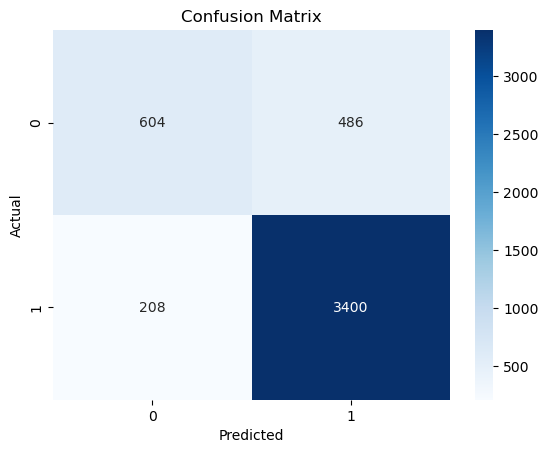

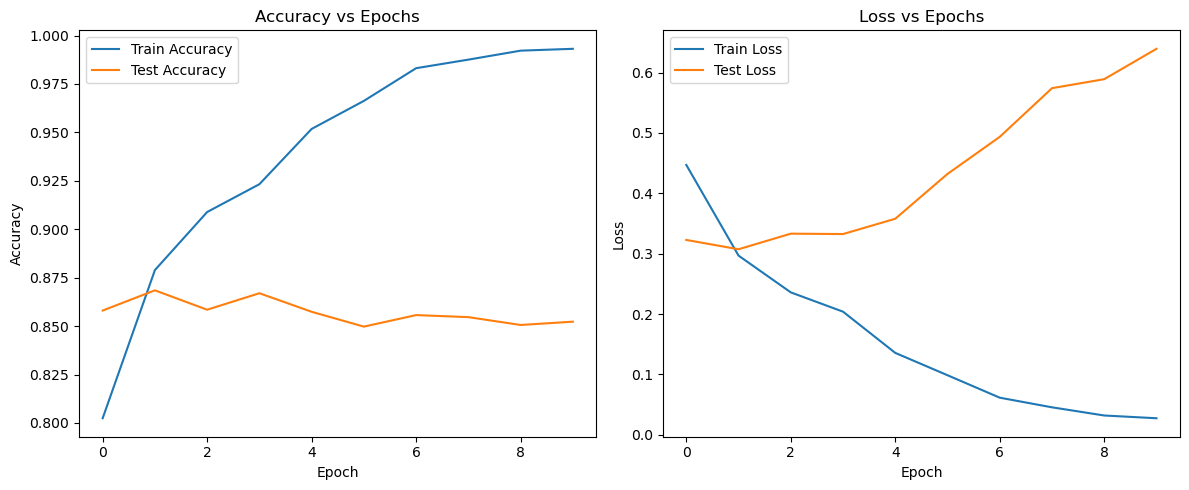

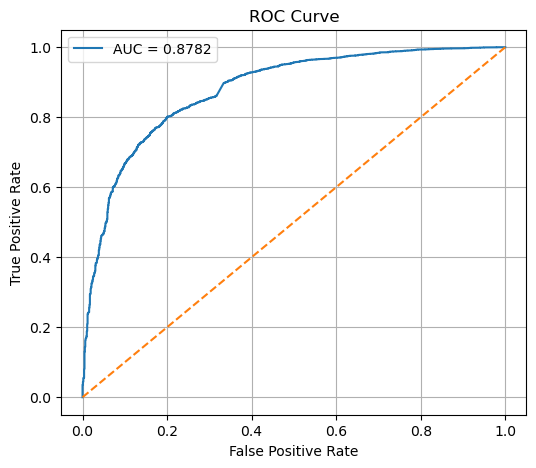


Information:
 1 : Recommended
 0 : Not Recommended


Sample Predictions:
1. Text: agree reviewer color isnt pink person subtle thoughts things __________ pros pockets makes fun chic ...
   True: 1, Pred: 1, Prob: 0.9858

2. Text: many sweaters bought sale soft comfortable...
   True: 1, Pred: 1, Prob: 0.9935

3. Text: beautiful top runs whole size small gave daughter loved...
   True: 1, Pred: 1, Prob: 0.9992

4. Text: loved pantsthey comfortable however wearing twice threads leaves fraying leaving lint whatever sit l...
   True: 0, Pred: 0, Prob: 0.0004

5. Text: ordered dress petite arrived regular rest fit meantime petites ran size dress long beautiful get sho...
   True: 1, Pred: 1, Prob: 0.9995

6. Text: cute shirt picked whitewithflowers shown online yet straight white looks like could wrinkle definite...
   True: 1, Pred: 0, Prob: 0.1640

7. Text: send back exchange way big im excited get smaller size really beautifully made...
   True: 0, Pred: 0, Prob: 0.0089

8. Text: liked 

In [3]:
# ======= RNN Model =======
class RNN_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.4):
        super(RNN_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()
        
        # Initialize weights for better convergence
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'embedding' in name:
                nn.init.uniform_(param, -0.1, 0.1)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # x shape: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]
        
        # RNN forward pass
        output, _ = self.rnn(embedded)  # [batch, seq_len, hidden_dim]
        
        # Global max pooling
        pooled, _ = torch.max(output, dim=1)  # [batch, hidden_dim]
        
        # Apply dropout before final layer
        pooled = self.dropout(pooled)
        
        # Final classification layer
        logits = self.fc(pooled).squeeze(1)  # [batch]
        return self.activation(logits)

# Initialize model, loss, and optimizer
model = RNN_Model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# ======= Train & Evaluate =======
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            total_loss += loss.item()

            preds = (probs >= 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return total_loss / len(loader), y_true, y_pred, y_prob

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        probs = model(x)
        loss = criterion(probs, y)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        preds = (probs >= 0.5).int()
        correct += (preds == y.int()).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Evaluate on test set
    test_loss, y_true, y_pred, y_prob = evaluate(model, test_loader, criterion)
    test_loss_hist.append(test_loss)
    test_acc = accuracy_score(y_true, y_pred)
    test_acc_hist.append(test_acc)
    
    # Update scheduler based on validation loss
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f} | Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

# ======= Metrics =======
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {test_acc_hist[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ======= Visualization =======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()

# ======= ROC Curve =======
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ======= Inspect some predictions =======
def get_sample_predictions(model, loader, n_samples=10):
    model.eval()
    samples = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            preds = (probs >= 0.5).int()
            
            for i in range(min(n_samples, len(x))):
                # Get the original text
                seq = x[i].cpu().numpy()
                # Convert sequence back to text
                idx_to_word = {idx: word for word, idx in vocabulary.items()}
                words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
                text = ' '.join(words)
                
                samples.append({
                    'text': text[:100] + '...',  # First 100 chars
                    'true': y[i].item(),
                    'pred': preds[i].item(),
                    'prob': probs[i].item()
                })
            
            if len(samples) >= n_samples:
                break
                
    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions(model, test_loader)
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()

# LSTM Model

Epoch 1: Train Accuracy=0.8261, Test Accuracy=0.8674 | Train Loss=0.4094, Test Loss=0.3031
Epoch 2: Train Accuracy=0.8942, Test Accuracy=0.8629 | Train Loss=0.2657, Test Loss=0.3046
Epoch 3: Train Accuracy=0.9145, Test Accuracy=0.8706 | Train Loss=0.2171, Test Loss=0.3051
Epoch 4: Train Accuracy=0.9405, Test Accuracy=0.8695 | Train Loss=0.1632, Test Loss=0.3325
Epoch 5: Train Accuracy=0.9504, Test Accuracy=0.8642 | Train Loss=0.1391, Test Loss=0.3667
Epoch 6: Train Accuracy=0.9624, Test Accuracy=0.8627 | Train Loss=0.1096, Test Loss=0.4230
Epoch 7: Train Accuracy=0.9669, Test Accuracy=0.8623 | Train Loss=0.0973, Test Loss=0.4602
Epoch 8: Train Accuracy=0.9723, Test Accuracy=0.8608 | Train Loss=0.0841, Test Loss=0.4932
Epoch 9: Train Accuracy=0.9751, Test Accuracy=0.8585 | Train Loss=0.0777, Test Loss=0.5393
Epoch 10: Train Accuracy=0.9776, Test Accuracy=0.8591 | Train Loss=0.0716, Test Loss=0.5424

Final Evaluation on Test Set:
Accuracy : 0.8591
Precision: 0.8928
Recall   : 0.9279
F1 S

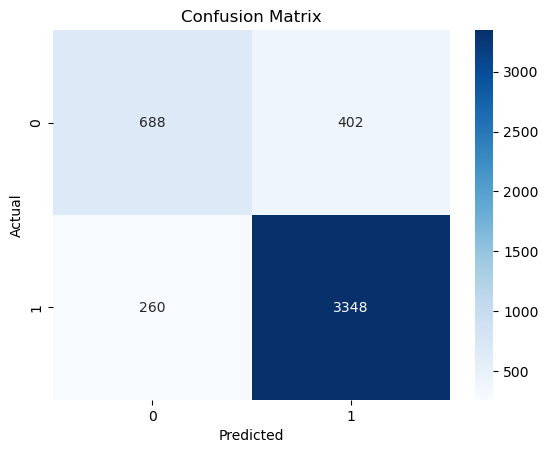

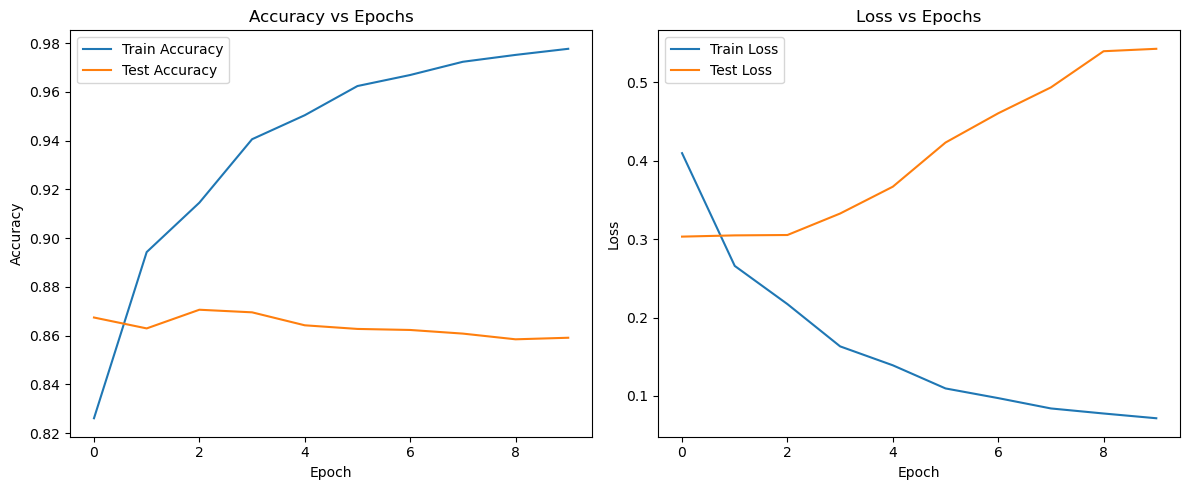

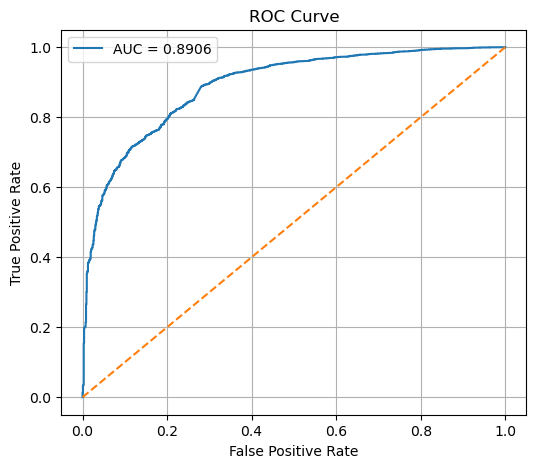


Information:
 1 : Recommended
 0 : Not Recommended


Sample Predictions:
1. Text: agree reviewer color isnt pink person subtle thoughts things __________ pros pockets makes fun chic ...
   True: 1, Pred: 1, Prob: 0.9970

2. Text: many sweaters bought sale soft comfortable...
   True: 1, Pred: 1, Prob: 0.9435

3. Text: beautiful top runs whole size small gave daughter loved...
   True: 1, Pred: 1, Prob: 0.9167

4. Text: loved pantsthey comfortable however wearing twice threads leaves fraying leaving lint whatever sit l...
   True: 0, Pred: 0, Prob: 0.0001

5. Text: ordered dress petite arrived regular rest fit meantime petites ran size dress long beautiful get sho...
   True: 1, Pred: 1, Prob: 0.9998

6. Text: cute shirt picked whitewithflowers shown online yet straight white looks like could wrinkle definite...
   True: 1, Pred: 1, Prob: 0.9995

7. Text: send back exchange way big im excited get smaller size really beautifully made...
   True: 0, Pred: 0, Prob: 0.0288

8. Text: liked 

In [4]:
# ======= LSTM Model =======
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.4):
        super(LSTM_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()
        
        # Initialize weights for better convergence
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'embedding' in name:
                nn.init.uniform_(param, -0.1, 0.1)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # x shape: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]
        
        # LSTM forward pass
        output, _ = self.lstm(embedded)  # [batch, seq_len, hidden_dim]
        
        # Global max pooling
        pooled, _ = torch.max(output, dim=1)  # [batch, hidden_dim]
        
        # Apply dropout before final layer
        pooled = self.dropout(pooled)
        
        # Final classification layer
        logits = self.fc(pooled).squeeze(1)  # [batch]
        return self.activation(logits)

# Initialize model, loss, and optimizer
model = LSTM_Model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# ======= Train & Evaluate =======
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            total_loss += loss.item()

            preds = (probs >= 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return total_loss / len(loader), y_true, y_pred, y_prob

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        probs = model(x)
        loss = criterion(probs, y)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        preds = (probs >= 0.5).int()
        correct += (preds == y.int()).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Evaluate on test set
    test_loss, y_true, y_pred, y_prob = evaluate(model, test_loader, criterion)
    test_loss_hist.append(test_loss)
    test_acc = accuracy_score(y_true, y_pred)
    test_acc_hist.append(test_acc)
    
    # Update scheduler based on validation loss
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f} | Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

# ======= Metrics =======
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {test_acc_hist[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ======= Visualization =======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()

# ======= ROC Curve =======
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ======= Inspect some predictions =======
def get_sample_predictions(model, loader, n_samples=10):
    model.eval()
    samples = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            preds = (probs >= 0.5).int()
            
            for i in range(min(n_samples, len(x))):
                # Get the original text
                seq = x[i].cpu().numpy()
                # Convert sequence back to text
                idx_to_word = {idx: word for word, idx in vocabulary.items()}
                words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
                text = ' '.join(words)
                
                samples.append({
                    'text': text[:100] + '...',  # First 100 chars
                    'true': y[i].item(),
                    'pred': preds[i].item(),
                    'prob': probs[i].item()
                })
            
            if len(samples) >= n_samples:
                break
                
    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions(model, test_loader)
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()

# GRU Model

Epoch 1: Train Accuracy=0.8388, Test Accuracy=0.8706 | Train Loss=0.3756, Test Loss=0.3038
Epoch 2: Train Accuracy=0.8996, Test Accuracy=0.8702 | Train Loss=0.2548, Test Loss=0.2992
Epoch 3: Train Accuracy=0.9188, Test Accuracy=0.8676 | Train Loss=0.2116, Test Loss=0.3432
Epoch 4: Train Accuracy=0.9378, Test Accuracy=0.8670 | Train Loss=0.1732, Test Loss=0.3304
Epoch 5: Train Accuracy=0.9574, Test Accuracy=0.8614 | Train Loss=0.1241, Test Loss=0.3805
Epoch 6: Train Accuracy=0.9672, Test Accuracy=0.8629 | Train Loss=0.0987, Test Loss=0.4593
Epoch 7: Train Accuracy=0.9775, Test Accuracy=0.8578 | Train Loss=0.0717, Test Loss=0.5357
Epoch 8: Train Accuracy=0.9814, Test Accuracy=0.8570 | Train Loss=0.0599, Test Loss=0.5593
Epoch 9: Train Accuracy=0.9858, Test Accuracy=0.8538 | Train Loss=0.0499, Test Loss=0.6536
Epoch 10: Train Accuracy=0.9870, Test Accuracy=0.8512 | Train Loss=0.0451, Test Loss=0.7141

Final Evaluation on Test Set:
Accuracy : 0.8512
Precision: 0.8819
Recall   : 0.9310
F1 S

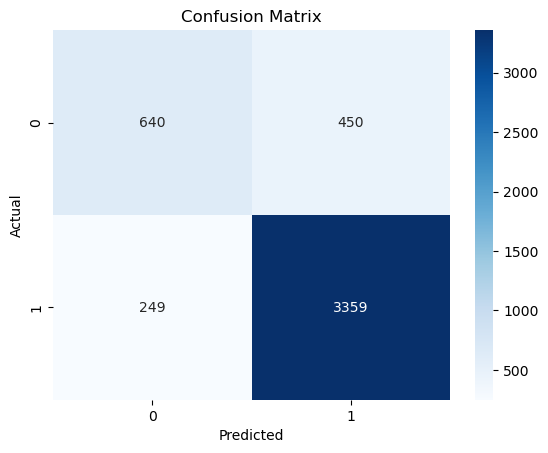

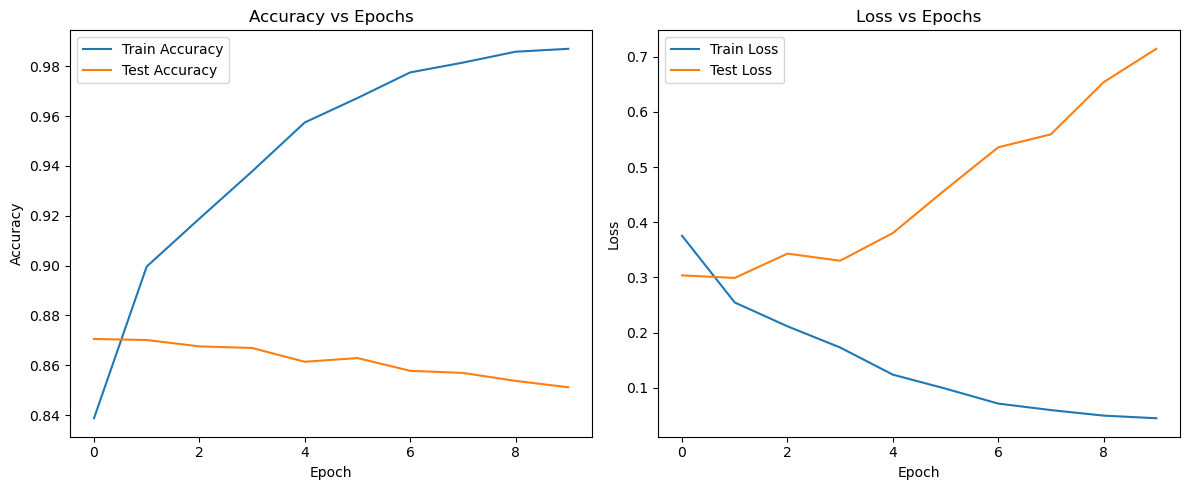

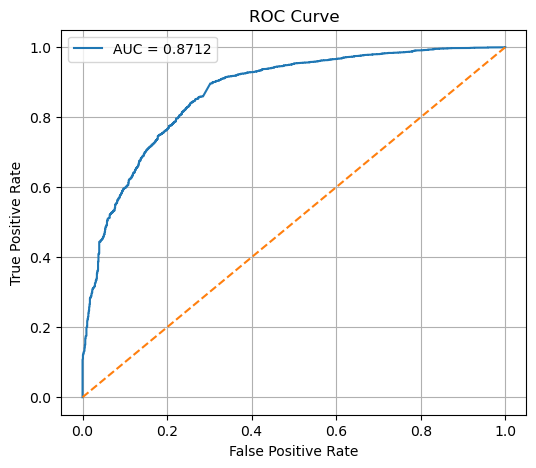


Information:
 1 : Recommended
 0 : Not Recommended


Sample Predictions:
1. Text: agree reviewer color isnt pink person subtle thoughts things __________ pros pockets makes fun chic ...
   True: 1, Pred: 1, Prob: 0.9998

2. Text: many sweaters bought sale soft comfortable...
   True: 1, Pred: 1, Prob: 0.9737

3. Text: beautiful top runs whole size small gave daughter loved...
   True: 1, Pred: 1, Prob: 0.9902

4. Text: loved pantsthey comfortable however wearing twice threads leaves fraying leaving lint whatever sit l...
   True: 0, Pred: 0, Prob: 0.0000

5. Text: ordered dress petite arrived regular rest fit meantime petites ran size dress long beautiful get sho...
   True: 1, Pred: 1, Prob: 0.9976

6. Text: cute shirt picked whitewithflowers shown online yet straight white looks like could wrinkle definite...
   True: 1, Pred: 1, Prob: 0.9999

7. Text: send back exchange way big im excited get smaller size really beautifully made...
   True: 0, Pred: 0, Prob: 0.2602

8. Text: liked 

In [7]:
# ======= GRU Model =======
class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.4):
        super(GRU_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()
        
        # Initialize weights for better convergence
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'embedding' in name:
                nn.init.uniform_(param, -0.1, 0.1)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # x shape: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]
        
        # GRU forward pass
        output, _ = self.gru(embedded)  # [batch, seq_len, hidden_dim]
        
        # Global max pooling
        pooled, _ = torch.max(output, dim=1)  # [batch, hidden_dim]
        
        # Apply dropout before final layer
        pooled = self.dropout(pooled)
        
        # Final classification layer
        logits = self.fc(pooled).squeeze(1)  # [batch]
        return self.activation(logits)

# Initialize model, loss, and optimizer
model = GRU_Model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# ======= Train & Evaluate =======
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            total_loss += loss.item()

            preds = (probs >= 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return total_loss / len(loader), y_true, y_pred, y_prob

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        probs = model(x)
        loss = criterion(probs, y)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        preds = (probs >= 0.5).int()
        correct += (preds == y.int()).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Evaluate on test set
    test_loss, y_true, y_pred, y_prob = evaluate(model, test_loader, criterion)
    test_loss_hist.append(test_loss)
    test_acc = accuracy_score(y_true, y_pred)
    test_acc_hist.append(test_acc)
    
    # Update scheduler based on validation loss
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f} | Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

# ======= Metrics =======
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {test_acc_hist[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ======= Visualization =======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()

# ======= ROC Curve =======
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ======= Inspect some predictions =======
def get_sample_predictions(model, loader, n_samples=10):
    model.eval()
    samples = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            preds = (probs >= 0.5).int()
            
            for i in range(min(n_samples, len(x))):
                # Get the original text
                seq = x[i].cpu().numpy()
                # Convert sequence back to text
                idx_to_word = {idx: word for word, idx in vocabulary.items()}
                words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
                text = ' '.join(words)
                
                samples.append({
                    'text': text[:100] + '...',  # First 100 chars
                    'true': y[i].item(),
                    'pred': preds[i].item(),
                    'prob': probs[i].item()
                })
            
            if len(samples) >= n_samples:
                break
                
    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions(model, test_loader)
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()

# Penjelasan Model, Visualisasi, dan Metrik

## 1. RNN (Recurrent Neural Network)

RNN menggunakan mekanisme **recurrence** untuk mengolah data urut seperti teks atau waktu. Formula utama yang digunakan dalam RNN adalah:

### Persamaan Dasar:
- **State Update**:
  $$
  h_t = f(W_h \cdot h_{t-1} + W_x \cdot x_t + b)
  $$
  - **Penjelasan**:
    - \($h_t$\): State tersembunyi pada waktu \(t\).
    - \($x_t$\): Input saat waktu \(t\).
    - \($W_h$\), \($W_x$\): Matriks bobot untuk state sebelumnya dan input saat ini.
    - \($b$\): Bias.
    - \($f$\): Fungsi aktivasi (contoh: tanh atau ReLU).

### Alur:
Pada setiap langkah waktu, RNN memperbarui state tersembunyi \($h_t$\) menggunakan input saat itu \($x_t$\) dan state sebelumnya \($h_{t-1}$\).

---

## 2. LSTM (Long Short-Term Memory)

LSTM mengatasi masalah **vanishing gradient** yang sering dialami RNN dengan menggunakan **gate mechanism**.

### Persamaan Dasar:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
   $$
   - **Fungsi**: Memutuskan informasi mana yang harus dibuang dari memori.

2. **Input Gate**:
   $$
   i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1}, x_t] + b_C)
   $$
   - **Fungsi**: Menghitung memori baru yang akan ditambahkan.

3. **Cell State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   - **Fungsi**: Memperbarui state sel.

4. **Output Gate**:
   $$
   o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$
   - **Fungsi**: Menghitung keluaran berdasarkan state sel yang diperbarui.

---

## 3. GRU (Gated Recurrent Unit)

GRU adalah versi sederhana dari LSTM tanpa cell state terpisah. Persamaan yang digunakan:

### Persamaan Dasar:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
   $$
   - **Fungsi**: Memutuskan informasi masa lalu yang harus dilupakan.

2. **Update Gate**:
   $$
   z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
   $$
   - **Fungsi**: Mengontrol berapa banyak informasi dari masa lalu yang akan dibawa ke state saat ini.

3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$
   - **Fungsi**: State tersembunyi diperbarui menggunakan reset dan update gate.

---

## 4. Visualisasi

### Akurasi:
Akurasi dihitung sebagai:
$$
\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Sampel}}
$$

### Loss:
Loss dalam pelatihan model dihitung menggunakan fungsi **Binary Cross Entropy (BCE)**:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label sebenarnya.
- \($\hat{y}_i$\): Probabilitas prediksi model.

### ROC Curve:
ROC Curve menunjukkan hubungan antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)**:
- **TPR**:
  $$
  TPR = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$
- **FPR**:
  $$
  FPR = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}
  $$

### AUC (Area Under Curve):
AUC mengukur area di bawah ROC Curve:
$$
\text{AUC} = \int_{0}^{1} TPR(FPR) \,dFPR
$$
Nilai AUC berkisar antara 0 hingga 1, dengan 1 menunjukkan prediksi sempurna.

---

## 5. Metrik

### Precision:
Precision mengukur seberapa tepat model dalam prediksi kelas positif:
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

### Recall:
Recall mengukur kemampuan model untuk mendeteksi semua kelas positif:
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

### F1 Score:
F1 Score adalah rata-rata harmonis antara precision dan recall:
$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

# Penjelasan Matematika PyTorch

## 1. Embedding Layer
Layer **`nn.Embedding`** digunakan untuk mengubah input indeks menjadi representasi vektor yang dapat dipelajari:
$$
E(x_t) = W_{embedding} \cdot x_t
$$
- **Dimensi**:
  - \($x_t$\): Input berupa indeks kata, dengan dimensi \($(batch\_size, sequence\_length)$\).
  - \($W_{embedding}$\): Matriks bobot dengan ukuran \($(\text{vocab\_size}, \text{embed\_dim})$\).
  - Output: Tensor dengan dimensi \($(batch\_size, sequence\_length, \text{embed\_dim})$\).

PyTorch secara otomatis memperbarui \($W_{embedding}$\) selama pelatihan untuk menghasilkan representasi kata yang bermakna.

---

## 2. RNN, GRU, dan LSTM
### **a. RNN (`nn.RNN`)**
Recurrent Neural Network (RNN) digunakan untuk memproses data sekuensial. Persamaan matematisnya adalah:
$$
h_t = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
$$
- \($h_t$\): State tersembunyi pada waktu \($t$\).
- \($W_{ih}$\): Bobot input ke hidden state (\($\text{input\_dim}$ $\to$ $\text{hidden\_dim}$\)).
- \($W_{hh}$\): Bobot antara hidden state (\($\text{hidden\_dim}$ $\to$ $\text{hidden\_dim}$\)).
- \($b_h$\): Bias.
- Fungsi aktivasi: **tanh**.

Output RNN adalah state tersembunyi pada setiap langkah waktu.

---

### **b. GRU (`nn.GRU`)**
GRU menggunakan mekanisme gate untuk menangani vanishing gradient:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_{ir} \cdot x_t + W_{hr} \cdot h_{t-1} + b_r)
   $$
   - Mengontrol seberapa banyak informasi masa lalu yang dilupakan.
2. **Update Gate**:
   $$
   z_t = \sigma(W_{iz} \cdot x_t + W_{hz} \cdot h_{t-1} + b_z)
   $$
   - Mengontrol informasi baru yang ditambahkan ke state.
3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot (r_t \odot h_{t-1}) + b_h)
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$

PyTorch menangani semua kalkulasi ini secara otomatis dalam layer GRU.

---

### **c. LSTM (`nn.LSTM`)**
LSTM memiliki struktur yang lebih kompleks dibanding GRU, dengan 3 jenis gate:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_{if} \cdot x_t + W_{hf} \cdot h_{t-1} + b_f)
   $$
2. **Input Gate**:
   $$
   i_t = \sigma(W_{ii} \cdot x_t + W_{hi} \cdot h_{t-1} + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_{ic} \cdot x_t + W_{hc} \cdot h_{t-1} + b_c)
   $$
3. **Output Gate**:
   $$
   o_t = \sigma(W_{io} \cdot x_t + W_{ho} \cdot h_{t-1} + b_o)
   $$
4. **State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$

Di PyTorch, `nn.LSTM` mengelola kedua state (\($h_t$\), \($C_t$\)) secara otomatis.

---

## 3. Dropout (`nn.Dropout`)
Layer `nn.Dropout` digunakan untuk regularisasi. Operasinya dapat dirumuskan sebagai:
$$
d_t = M \cdot h_t
$$
- \($M$\): Mask binari yang dihasilkan dengan probabilitas \($p$\) untuk dropout.

Dropout diaktifkan selama pelatihan (`model.train()`) tetapi tidak diterapkan saat evaluasi (`model.eval()`).

---

## 4. Fully Connected Layers (`nn.Linear`)
Layer `nn.Linear` adalah transformasi linier sederhana:
$$
y_t = W \cdot h_t + b
$$
- \($W$\): Matriks bobot (\($\text{hidden\_dim} \to \text{output\_dim}$\)).
- \($b$\): Bias.

Fungsi aktivasi seperti `ReLU` atau `Sigmoid` diterapkan setelah `nn.Linear` untuk menambahkan non-linearitas.

---

## 5. Binary Cross-Entropy Loss (BCELoss)
Loss dihitung menggunakan rumus:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label sebenarnya (0 atau 1).
- \($\hat{y}_i$\): Probabilitas prediksi setelah fungsi sigmoid.

---

## 6. GradScaler
PyTorch mendukung precision campuran dengan `torch.amp.GradScaler` untuk mencegah angka terlalu kecil atau besar:
- **Forward Pass**:
  $$ \text{loss} = \text{criterion}(output, label) $$
- **Gradient Scaling**:
  $$ \text{scaled\_loss} = \text{scale} \cdot \text{loss} $$
- Setelah backward pass:
  $$ \text{gradients} = \frac{\partial (\text{scaled\_loss})}{\partial (\text{parameters})} $$

Scaler memperbarui bobot sambil mempertahankan stabilitas numerik.

---

## 7. ReduceLROnPlateau
Scheduler ini mengurangi learning rate berdasarkan stagnasi pada loss validasi:
$$
\text{lr\_new} = \text{lr\_old} \times \text{factor}
$$
Dengan **PyTorch**:
```python
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)
scheduler.step(test_loss)
